In [1]:
import pandas as pd
import numpy as np
import awswrangler as wr
import re

from matplotlib import pyplot as plt
import seaborn as sb

import statsmodels.api as sm
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import os
from plotly.offline import  init_notebook_mode 
init_notebook_mode(connected=True)

from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.max_columns', None)
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


In [2]:
#read data
df=pd.read_csv('media_data.csv')
df.head()


,GEO,WEEK_START,YT_PAID_IMP,YT_ORG_IMP,GOOGLE_IMP,EMAIL_IMP,FB_IMP,AFF_IMP,GOOGLE_SPEND,FB_SPEND,AFF_SPEND,REVENUE
0,A,1/6/18,392,422,408,349895,73580,12072,3.75,910.55,285.20,59417
1,A,1/13/18,787,904,110,506270,11804,9499,2.57,154.04,209.45,56806
2,A,1/20/18,81,970,742,430042,52232,17048,13.76,1151.72,295.36,48715
3,A,1/27/18,25,575,65,417746,78640,10207,0.74,2229.44,273.29,72047
4,A,2/3/18,565,284,295,408506,40561,5834,3.66,857.87,101.07,56235


In [3]:
df.columns

Index(['GEO', 'WEEK_START', 'YT_PAID_IMP', 'YT_ORG_IMP', 'GOOGLE_IMP',
       'EMAIL_IMP', 'FB_IMP', 'AFF_IMP', 'GOOGLE_SPEND', 'FB_SPEND',
       'AFF_SPEND', 'REVENUE'],
      dtype='object')

In [4]:
factors=['YT_PAID_IMP', 'YT_ORG_IMP', 'GOOGLE_IMP',
       'EMAIL_IMP', 'FB_IMP', 'AFF_IMP', 'GOOGLE_SPEND', 'FB_SPEND',
       'AFF_SPEND']
metric='REVENUE'

In [5]:
def plot_correlation_heatmap(level2_df,y_cols):
    #pageviews delta vs themes corelation
    plt.figure(figsize=(20,5))
    sns.heatmap(round(level2_df.corr()[y_cols:],2),annot=True)
    plt.subplots_adjust(bottom=0.5)

def OLS_tstats_coefficient(df,x_cols,y_cols):
    #OLS
    X_data = sm.add_constant(df[x_cols])
    result_pg_delta = sm.OLS(df[y_cols].astype(float), np.asarray(X_data.astype(float))).fit()
    print(result_pg_delta.summary())
    tstats_df=result_pg_delta.tvalues[1:]
    tstats_df.index=x_cols
    #plot tstats
    plt.figure(figsize=(20,10))
    ax1=sns.barplot(y=round(tstats_df,2),x=tstats_df.index)
    plt.xticks(rotation=90)
    ax1.bar_label(ax1.containers[0])
    ax1.set_title('T-stats for theme')

    plt.text(.05, .8, "R-squared:{:.2f}".format(round(result_pg_delta.rsquared*100,2)),transform=ax1.transAxes)
    plt.text(.05, .85, "Adj. R-squared:{:.2f}".format(round(result_pg_delta.rsquared_adj*100,2)),transform=ax1.transAxes)
    plt.subplots_adjust(bottom=0.4)

    
    #plot themes coefficient
    coef_df=result_pg_delta.params[1:]
    coef_df.index=x_cols
    plt.figure(figsize=(20,10))
    ax2=sns.barplot(y=round(coef_df,2),x=coef_df.index)
    plt.xticks(rotation=90)
    ax2.bar_label(ax2.containers[0])
    ax2.set_title('Coeficient values for theme')

    round(result_pg_delta.rsquared_adj *100,2)
    plt.text(.05, .8, "R-squared:{:.2f}".format(round(result_pg_delta.rsquared*100,2)),transform=ax2.transAxes)
    plt.text(.05, .85, "Adj. R-squared:{:.2f}".format(round(result_pg_delta.rsquared_adj*100,2)),transform=ax2.transAxes)
    plt.subplots_adjust(bottom=0.4)



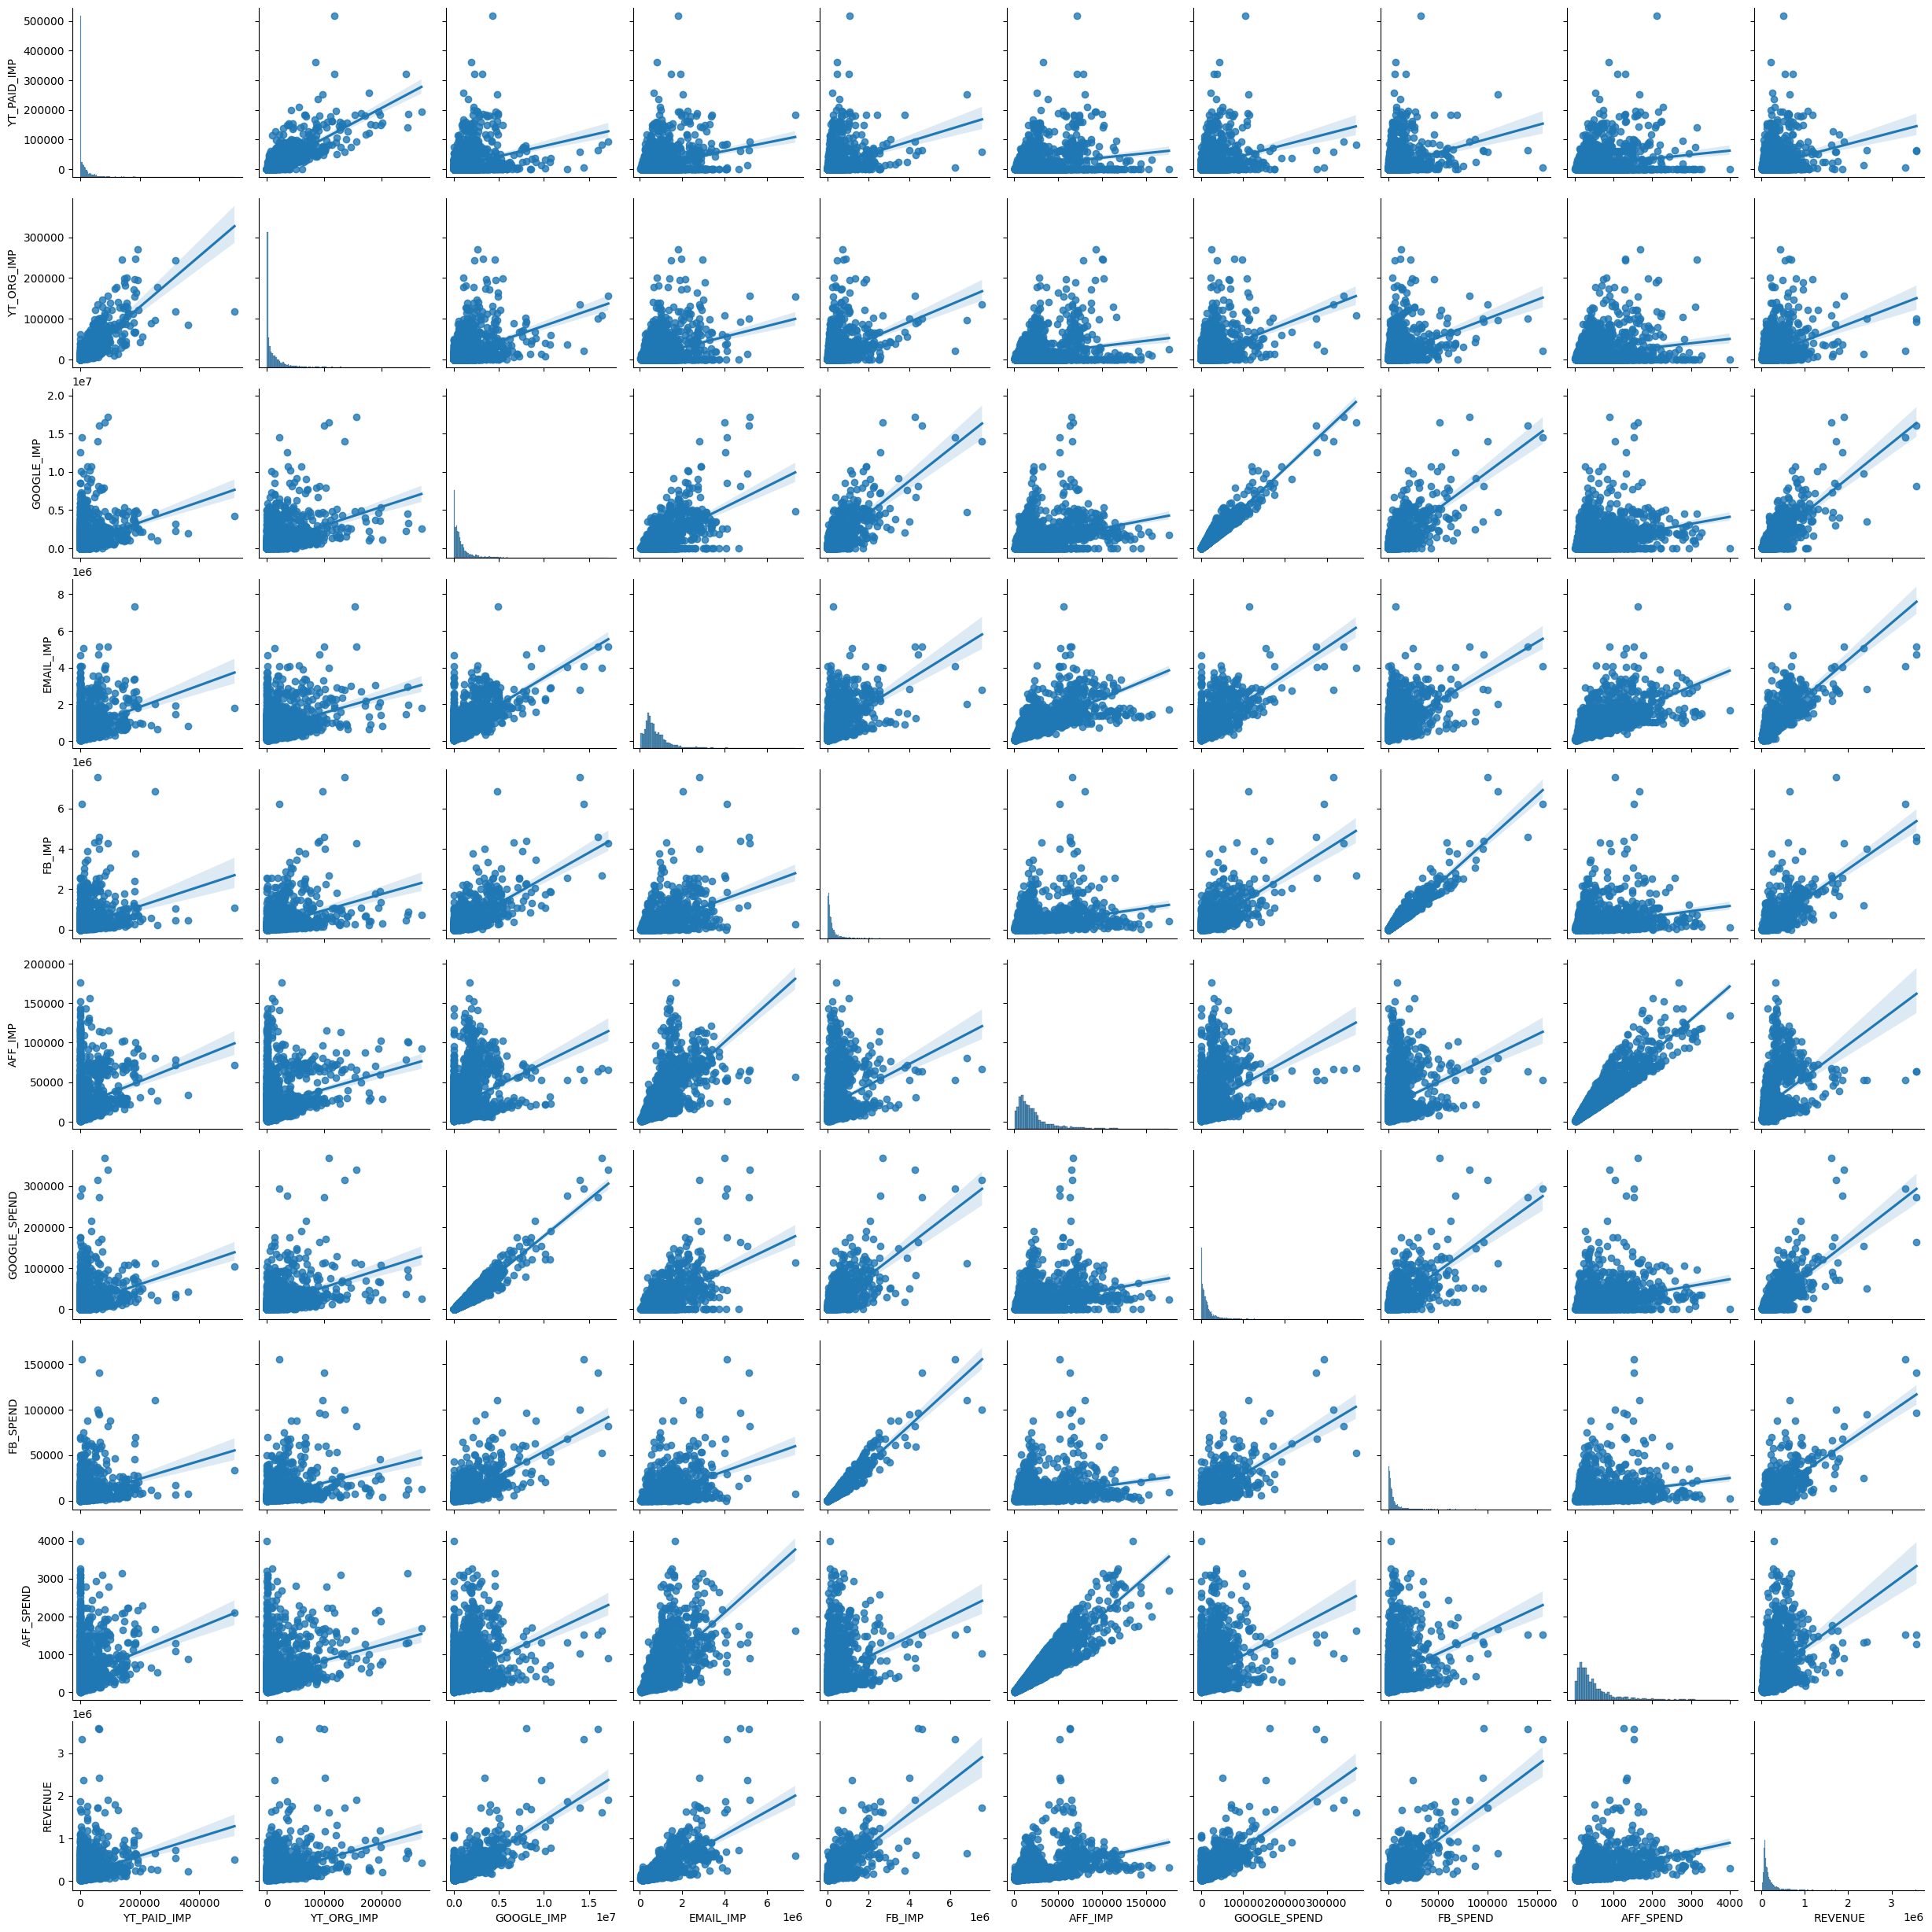

In [6]:
#pairplot analysis of all features
sns.pairplot(df,kind='reg')

- As we can see from above pairplot analysis impression and spend for respective channels have high  colrelation, hence model results can suffer from multicolinearity problem.
- Also there few of features like google_imp,emial_imp,fb_imp,google_spend and fb_spend has linear corelation  with revenue, where as remaining doesn't


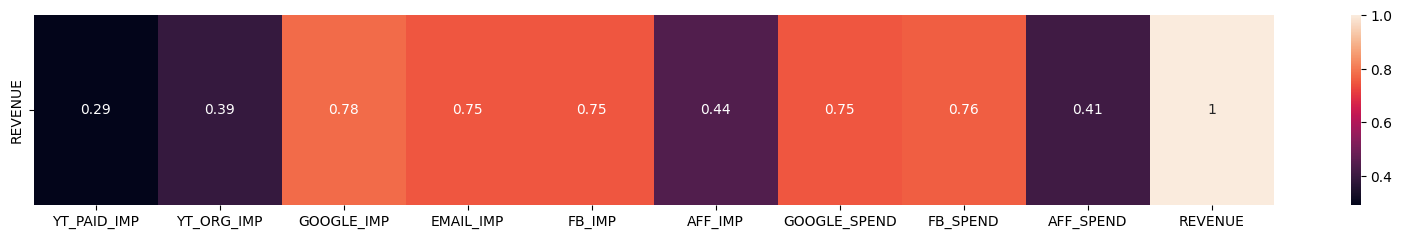

In [7]:
#check linear corelation
plot_correlation_heatmap(df[factors+[metric]],metric)

**1. Which marketing channels influence revenue the most? The least? How confident are you in these results?**


                            OLS Regression Results                            
Dep. Variable:                REVENUE   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1206.
Date:                Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:37:38   Log-Likelihood:                -39707.
No. Observations:                3051   AIC:                         7.943e+04
Df Residuals:                    3041   BIC:                         7.949e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9791.9086   3192.962     -3.067      0.0

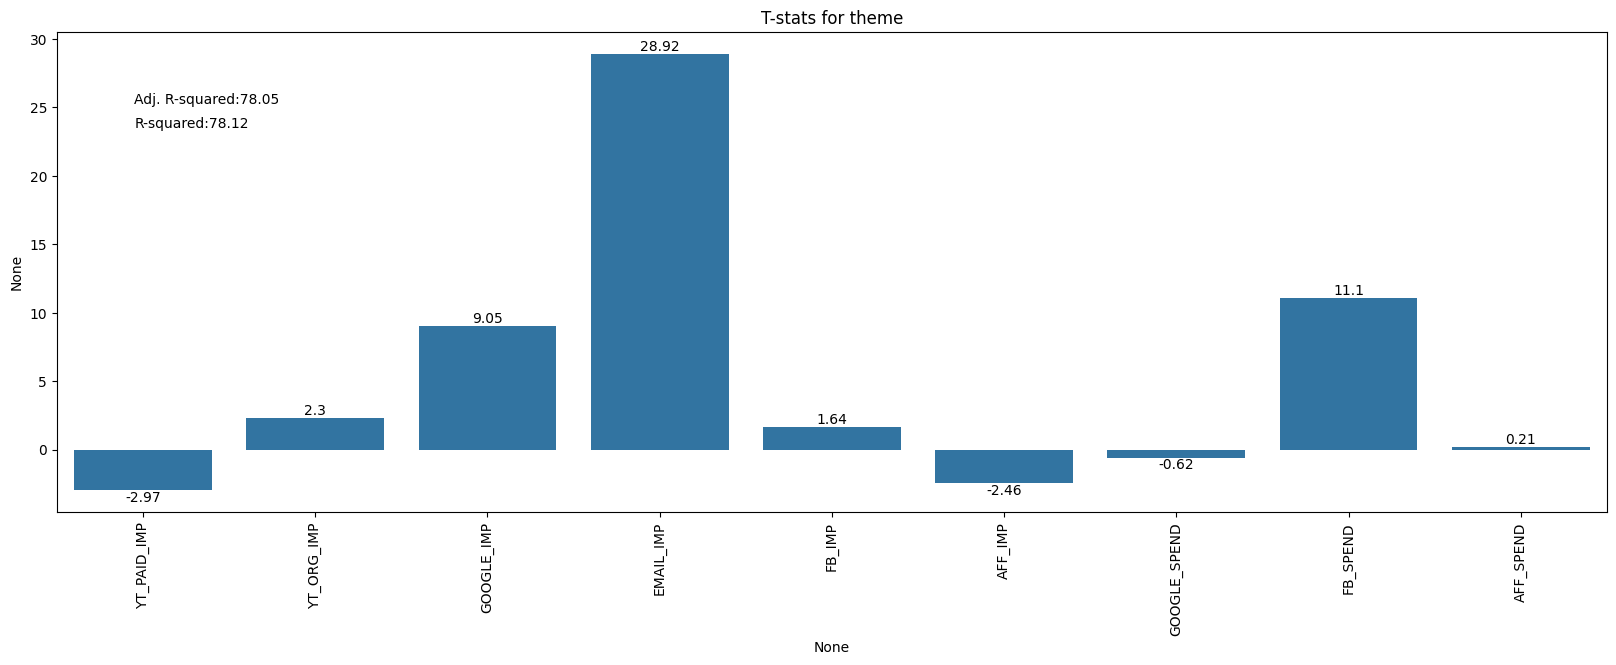

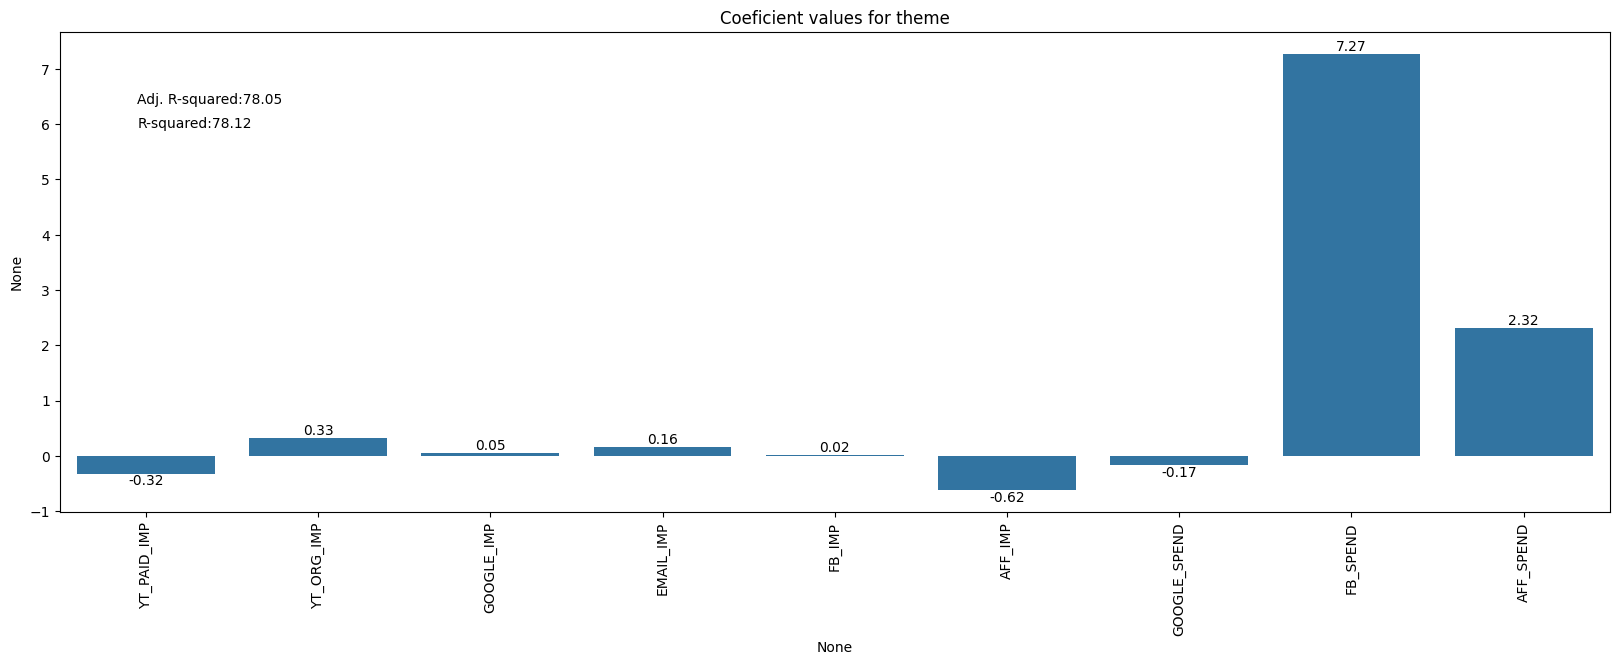

In [8]:
#Let's try to check channel  efficacy using simple OLS model
OLS_tstats_coefficient(df,factors,metric)

In [9]:
#From p values we can see that p value for the below factors is more then 5% , hence those factors aren't that significant
[factors[4],factors[6],factors[8]]

['FB_IMP', 'GOOGLE_SPEND', 'AFF_SPEND']

In [10]:
#Important factors based on p value
[ele for ele in factors if ele not in [factors[4],factors[6],factors[8]]]

['YT_PAID_IMP', 'YT_ORG_IMP', 'GOOGLE_IMP', 'EMAIL_IMP', 'AFF_IMP', 'FB_SPEND']

**It's noticeable that spend on Facebook and Affiliate channel is much higher than other channels**

Considering multicolinearity between features and Non linear relationship between  some of the features, ensemble model would be better to identify the feature/factor importance

        Feature  Importance
2    GOOGLE_IMP    0.408313
3     EMAIL_IMP    0.265292
4        FB_IMP    0.141073
7      FB_SPEND    0.075534
5       AFF_IMP    0.035585
6  GOOGLE_SPEND    0.026258
1    YT_ORG_IMP    0.016914
0   YT_PAID_IMP    0.015587
8     AFF_SPEND    0.015443


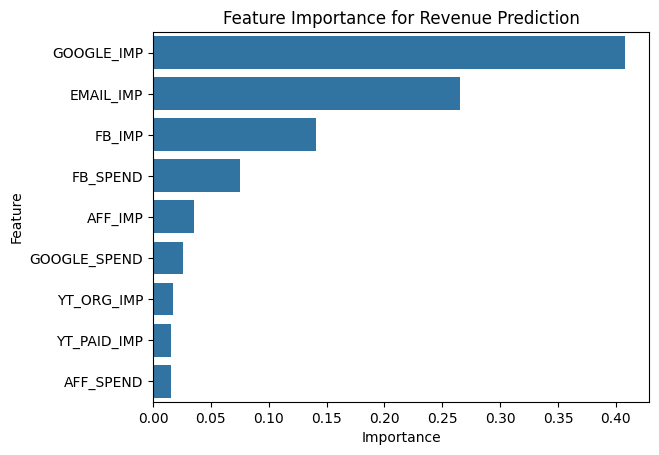

In [11]:
#RandomForest model
X = df[factors]
y = df[metric]

# Train Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

# Feature importance
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
importances.sort_values(by='Importance', ascending=False, inplace=True)
print(importances)
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title("Feature Importance for Revenue Prediction")
plt.show()


**Top Channels Influencing Revenue**
- GOOGLE_IMP: 40.8% importance.
- EMAIL_IMP: 26.5%.
- FB_IMP: 14.1%


**Google** and **Email Impressions** strongly influences Revenue, **Facebook impressions and Spend** impacts moderately 

**2. Is the business allocating spend across channels efficiently? If not, how would you reinvest or allocate your budget?**

In [12]:
# Calculate Return On Investment for each channel, to check if channel is efficient or not
df['Google_ROI'] = df['REVENUE'] / df['GOOGLE_SPEND']
df['Facebook_ROI'] = df['REVENUE'] / df['FB_SPEND']
df['Affiliate_ROI'] = df['REVENUE'] / df['AFF_SPEND']


Google ROI: 10171.184550102418
Facebook ROI: 456.7788993840854
Affiliate ROI: 600.7300444583196


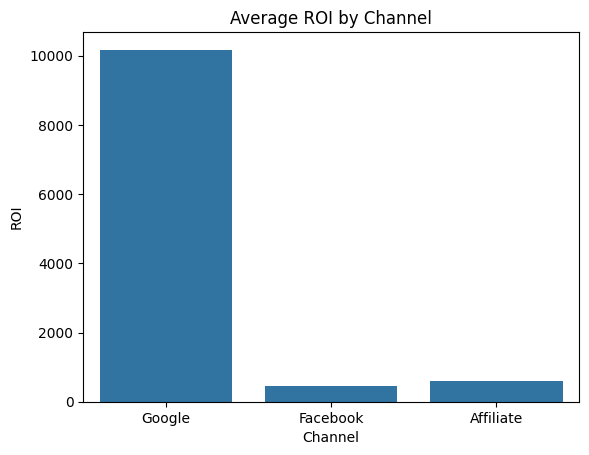

In [13]:
df.replace([float('inf'), -float('inf')], 0, inplace=True)
df.fillna(0, inplace=True)

# Print average ROI for each channel
print("Google ROI:", df['Google_ROI'].mean())
print("Facebook ROI:", df['Facebook_ROI'].mean())
print("Affiliate ROI:", df['Affiliate_ROI'].mean())


# ROI by Channel
roi_data = pd.DataFrame({
    'Channel': ['Google', 'Facebook', 'Affiliate'],
    'ROI': [df['Google_ROI'].mean(), df['Facebook_ROI'].mean(), df['Affiliate_ROI'].mean()]
})

sns.barplot(x='Channel', y='ROI', data=roi_data)
plt.title("Average ROI by Channel")
plt.show()


- Google ROI: High, more efficient spending.
- Facebook ROI: Moderate, but room for reinvestment.
- Affiliate ROI: Low, inefficient spending.

Also from above OLS model analysis we saw that spend on Facebook and Affiliate channel is much higher then other channels, while ROI for facebook and affiliate is very less than Google channel. Hence need change in budget allocation strategy.

**3. Efficiency Across Geographies**

In [14]:
geo_efficiency = df.drop(columns='WEEK_START').groupby('GEO').mean()
print(geo_efficiency[['Google_ROI', 'Facebook_ROI', 'Affiliate_ROI']])

        Google_ROI  Facebook_ROI  Affiliate_ROI
GEO                                            
A      2016.313383    225.212330     815.498133
B     42897.042018   1186.751915     681.166408
C     23663.907334    803.389284    2150.130603
D      3831.683882    243.831826     478.320549
E      6375.760964    318.617121     313.887190
F      3745.684790    127.210626     444.828596
G      3876.936776    336.915933     443.630978
H      1534.028693    110.510097     543.940305
I      1701.577941    113.760393     424.204089
J      1244.518298    122.772874     432.278213
K      2047.178978    341.003017     555.029730
L      4080.338448    431.164005     675.693541
M      3932.008680    102.926229     407.422725
N    119511.096559    151.831580     655.682825
O      5853.543644   3585.393273     600.867848
P      1515.925186    128.086080     523.328119
Q      2616.610508    177.824746     500.840681
R      1785.093023    184.907174     897.355866
S      7682.460460    918.380467     498

As we can see for majority of geographies, the pattern for ROI remains same for **Google, Facebook and Affiliate** in terms of magnitude.

Like ROI follows **Google>Affiliate>Facebook** pattern which is aligned with the overall average

Except for very few geographies like **B, O and S** we can see ROI for **facebook is greater then Affiliates**.


**Model Adjustments to incoporate GEO level differences:**
- If required, we can consider separate models for each GEO 


**Recommendations:**
- To optimize budget allocation, reallocate budget from low-ROI channels (AFF_SPEND) to high-ROI channels (GOOGLE_SPEND or FB_SPEND).
- Continuously monitor spend vs revenue relationships to define dynamic budget allocation strategies
- Also consider goegraphies while  adjusting strategies